In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from typing import Tuple, Optional
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.manifold import TSNE
sys.path.append('../code')
from config import DL_MODELS, DL_MODELS_IMAGE_BASED, ML_MODELS
from dataloader.dataset import load_data
from hparams_tuner.ml_models_tuner import MLModelTuner
from hparams_tuner.dl_models_tuner import DLModelTuner
from evaluate_model import Model_Evaluation
from tabmap_construction import TabMapGenerator

### Load example dataset PD
Dataset source: [Parkinson's Disease Classification](https://archive.ics.uci.edu/dataset/470/parkinson+s+disease+classification)

In [2]:
data_path='../data'
data_set='parkinson'

# Define paths and ensure directory existence
data_dir = os.path.join(data_path, data_set)
os.makedirs(os.path.dirname(data_dir), exist_ok=True)

# Load the dataset
features, labels, feature_names = load_data(data_dir, scaler_name='minmax', preprocessed=False)
n_classes = len(np.unique(labels))

# Define paths to save classification results
results_path = f'../results/{data_set}'

Performing data preprocessing...
Discarded features: []
0.0 -> 0
1.0 -> 1


### Compare different classifiers for Parkinson's diease classification task
In addition to our proposed TabMap-based classifier, we also performed evaluations on other comparison methods, including:
- [DeepInsight](https://github.com/alok-ai-lab/pyDeepInsight)
- [TabTransformer](https://github.com/lucidrains/tab-transformer-pytorch)
- [Soft-ordering 1D CNN](https://medium.com/spikelab/convolutional-neural-networks-on-tabular-datasets-part-1-4abdd67795b6) (1DCNN)
- [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) (LR)
- [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) (RF)
- [Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) (GB)
- [XGBoost](https://xgboost.readthedocs.io/en/stable/) (XGB) 

In [3]:
# To install and run DeepInsight, please refer to the setup instructions 
# on their GitHub page (https://github.com/alok-ai-lab/pyDeepInsight).
# !pip install "git+https://github.com/alok-ai-lab/pyDeepInsight.git#egg=pyDeepInsight" --quiet
from pyDeepInsight import ImageTransformer
model_list = ['TabMap', 'DeepInsight', 'TabTransformer', '1DCNN', 'LR', 'RF', 'GB', 'XGB']

In [4]:
def generate_images(model_id: str, 
                    features: np.ndarray, 
                    train_idx: list, 
                    test_idx: list,
                    save_path: Optional[str]=None, 
                    save_images: bool=True) -> Tuple[np.ndarray, float]:
    print(f"Generating images for {model_id}")
    
    if model_id not in DL_MODELS_IMAGE_BASED:
        raise ValueError(f"Unsupported model_id: {model_id}")
    
    if model_id == 'TabMap':
        generator = TabMapGenerator(metric='correlation', loss_fun='kl_loss')
        generator.fit(features[train_idx], truncate=False)
        X_train_img = generator.transform(features[train_idx])
        X_test_img = generator.transform(features[test_idx])
    
    elif model_id == 'DeepInsight':
        reducer = TSNE(n_components=2, metric='cosine', perplexity=5)
        generator = ImageTransformer(feature_extractor=reducer, pixels=(50, 50))
        generator.fit(features[train_idx])
        X_train_img = generator.transform(features[train_idx], img_format='scalar')
        X_test_img = generator.transform(features[test_idx], img_format='scalar')
    
    images = np.empty((len(features), X_train_img.shape[1], X_train_img.shape[2]))
    images[train_idx] = X_train_img
    images[test_idx] = X_test_img
    
    if save_images and save_path:
        # this is recommended as our model training will load saved files.
        np.save(save_path, images) 
        print(f"Images saved to {save_path}")
    
    return images, generator

In [5]:
seed = 42
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# set seed
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

predictions_test_df = pd.DataFrame()
performance_test_df = pd.DataFrame()

skf = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=seed)
for fold_id, (train_idx_all, test_idx) in enumerate(skf.split(features, labels)):
    print(f'\nFold_id: {fold_id}')
    train_idx, valid_idx = train_test_split(train_idx_all, test_size=0.125,
                                            random_state=seed,
                                            stratify=labels[train_idx_all])
    
    images_dict = {}
    for model_id in model_list:
        print(f"\nTraining {model_id}...")
        if model_id in DL_MODELS_IMAGE_BASED:
            images_save_path = os.path.join(data_dir, f"{model_id}.npy")
            images, generator = generate_images(model_id, features, train_idx_all, test_idx, 
                                                save_path=images_save_path)
            images_dict[model_id] = images
        
        data_config = {
            "data_set": data_set,
            "data_dir": data_dir,
            "n_classes": n_classes,
            "input_size": images_dict[model_id].shape[1:] \
                if model_id in DL_MODELS_IMAGE_BASED else features.shape[1],
            "fold_id": fold_id,
        }
        
        if model_id in DL_MODELS:
            tuner = DLModelTuner(data_config, train_idx, valid_idx, model_id, 
                    results_path, 
                    use_default_hparams=True,
                    opt_metric='loss',
                    random_seed=seed)
        
        elif model_id in ML_MODELS:
            tuner = MLModelTuner(data_config, train_idx, valid_idx, model_id, 
                    results_path, 
                    use_default_hparams=True,
                    random_seed=seed)
        
        best_params_dict = tuner.params_dict
        best_params_dict['fold'] = fold_id
        
        # Model evaluation on the best trained model
        model_eval = Model_Evaluation(model_id)
        if model_id in DL_MODELS_IMAGE_BASED:
            #  _, y_pred = model_eval.model_predict(tuner.final_model, features=images_dict[model_id][test_idx], multilabel=False)
            _, y_pred = model_eval.model_predict(tuner.final_model, features=images_dict[model_id][test_idx])
        else:
            # _, y_pred = model_eval.model_predict(tuner.final_model, features=features[test_idx], multilabel=False)
            _, y_pred = model_eval.model_predict(tuner.final_model, features=features[test_idx])
        
        performance_test = model_eval.prediction_performance(labels[test_idx].ravel(), y_pred.ravel())
        performance_test = pd.DataFrame([performance_test])
        performance_test["fold"] = fold_id
        performance_test_df = pd.concat([performance_test_df, performance_test])


Fold_id: 0

Training TabMap...
Generating images for TabMap
Solving optimization problem...
Images saved to ../data/parkinson/TabMap.npy
Epoch 17/30: Train Loss: 0.0001, Val Loss: 0.0105, Val Acc: 0.8070
Early stopping triggered

Training DeepInsight...
Generating images for DeepInsight
Images saved to ../data/parkinson/DeepInsight.npy
Epoch 16/30: Train Loss: 0.0002, Val Loss: 0.0169, Val Acc: 0.8070
Early stopping triggered

Training TabTransformer...
Epoch 9/50: Train Loss: 0.0051, Val Loss: 0.0088, Val Acc: 0.8158
Early stopping triggered

Training 1DCNN...
Epoch 18/30: Train Loss: 0.0007, Val Loss: 0.0145, Val Acc: 0.7982
Early stopping triggered

Training LR...

Training RF...

Training GB...

Training XGB...

Fold_id: 1

Training TabMap...
Generating images for TabMap
Solving optimization problem...
Images saved to ../data/parkinson/TabMap.npy
Epoch 30/30: Train Loss: 0.0001, Val Loss: 0.0070, Val Acc: 0.9123
Training DeepInsight...
Generating images for DeepInsight
Images save

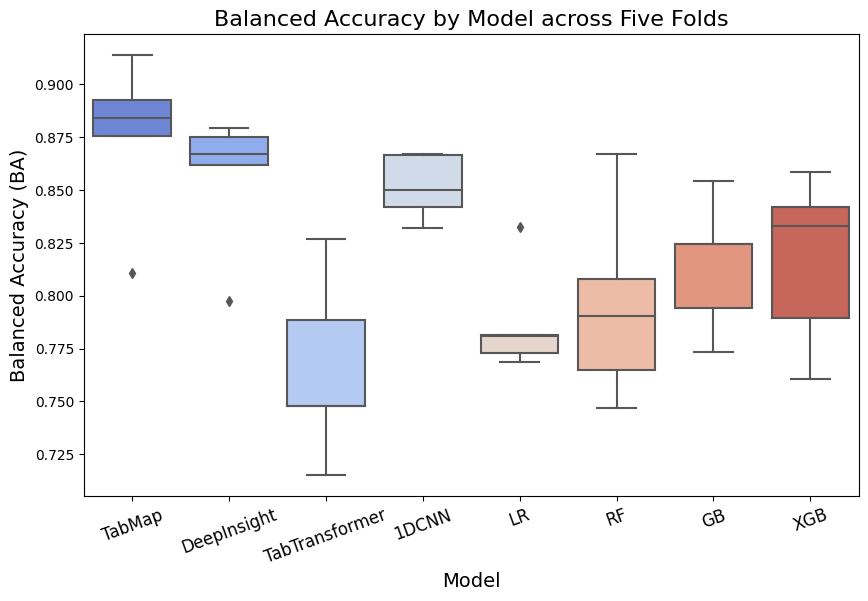

In [7]:
import seaborn as sns
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(data=performance_test_df, x='model', y='BA', palette='coolwarm')

plt.title('Balanced Accuracy by Model across Five Folds', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Balanced Accuracy (BA)', fontsize=14)
plt.xticks(rotation=20, fontsize=12)
plt.show()